In [10]:
from sklearn.metrics import accuracy_score
import numpy as np
from detect_outlier import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from support_function.labeling_from_score import labeling



In [11]:
df_normalized = read_data()
df_normalized.dropna(inplace=True)


In [12]:
X = np.array(
    df_normalized[
        [
            "totalAsset",
            "averageTotalAsset",
            "frequencyMountOfTransaction",
            "borrow_per_balance",
            "deposit_per_asset",
            "borrow_per_deposit",
            "totalValueOfLiquidation",
            "numberOfLiquidation",
            "frequencyOfTransaction",
            "frequencyOfDappTransactions",
            "numberOfInteractedDapps",
            "typesOfInteractedDapps",
            "numberOfReputableDapps",
            "age",
        ]
    ].values
)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = (
    train_test_split(
            X, first_y, second_y, test_size=0.2, stratify=second_y, random_state=40
        )
)
# Chuẩn bị dữ liệu

In [13]:
# def new_error_func(y, second_y, y_pred):
#     errors = [0] * len(y_pred)
#     # Lặp qua từng phần tử trong mảng
#     for i in range(len(y_pred)):
#         if y[i] > second_y[i]:
#             errors[i] = y_pred[i] - y[i]
#         else:
#             errors[i] = y_pred[i] - second_y[i]
#     return errors


def new_error_func(first_y, second_y, y_pred):
    errors = [0] * len(y_pred)
    for i in range(len(y_pred)):
        if first_y[i] == second_y[i]:
            errors[i] = y_pred[i] - first_y[i]
        else:
            min_value = min(first_y[i], second_y[i])
            max_value = max(first_y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def adam(
    X,
    y,
    second_y,
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    num_iterations=10000,
):
    # Khởi tạo vector trọng số ngẫu nhiên
    w = np.random.uniform(0, 1, X.shape[1])
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    t = 0

    for _ in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        # Tính gradient của hàm lỗi cho mẫu đã chọn
        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        # Tính trung bình độ lớn của gradient và gradient bình phương
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)

        # Bias correction
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))

        w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        t += 1

    return w


learned_weights = adam(X_train, first_y_train, second_y_train)

print("Vector trọng số tối ưu:", learned_weights)

Vector trọng số tối ưu: [ 0.014155    0.18249642  0.02188866  0.072527    0.01317638 -0.0016175
  0.25030318  0.36722574  0.096591    0.25985245 -0.14033264  0.02193074
 -0.28643129  0.00042371]


In [14]:
# max1 = 0
# res = None
# for i in range(10):
#     learned_weights = adam(X_train, first_y_train, second_y_train)
#     pred = labeling(X_test.dot(learned_weights))
#     acc = new_accuracy(first_y_test, second_y_test, pred)
#     if acc > max1:
#         max1 = acc
#         res = learned_weights

In [15]:
predicted_labels = labeling(X_test.dot(learned_weights))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))
# print(new_f1_score(first_y_test, second_y_test, predicted_labels))
# print(precision_recall(first_y_test, second_y_test, predicted_labels))

0.8885743047690953


In [16]:
first_label = first_y_test
second_label = second_y_test
pred_label = predicted_labels

In [17]:
precision_recall(first_label, second_label, pred_label)

Precision: {1: 0.8990749793186433, 2: 0.9173457508731082, 3: 0.6666666666666666, 4: 0.6875, 0: 0.7283950617283951}
Recall: {1: 0.9926928506186167, 2: 0.512187195320117, 3: 0.8710801393728222, 4: 0.2, 0: 0.8428571428571429}
F1 Score: {1: 0.9435674822415154, 2: 0.6573514077163713, 3: 0.755287009063444, 4: 0.3098591549295775, 0: 0.7814569536423841}
Average Precision: 0.7797964917173626
Average Recall: 0.6837634656337398
Average F1 Score: 0.6895044015186584
Weighted Precision: 0.8885743047690953
Weighted Recall: 0.9318583093832108
Weighted F1 Score: 0.9010056020700512


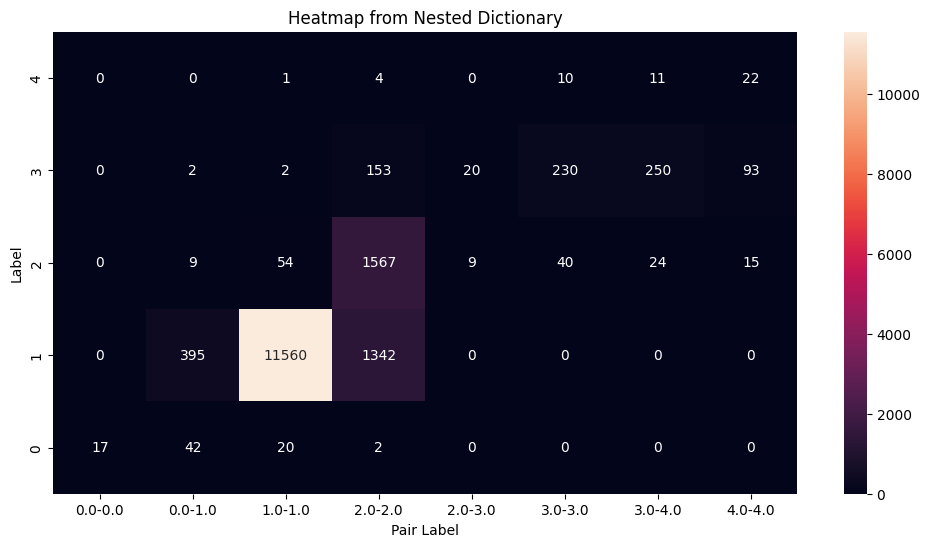

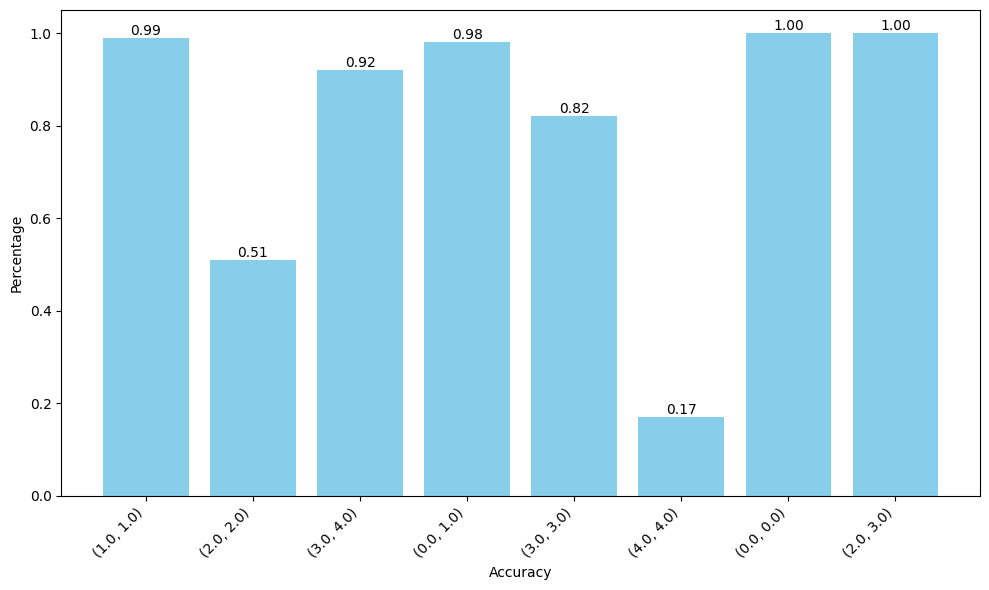

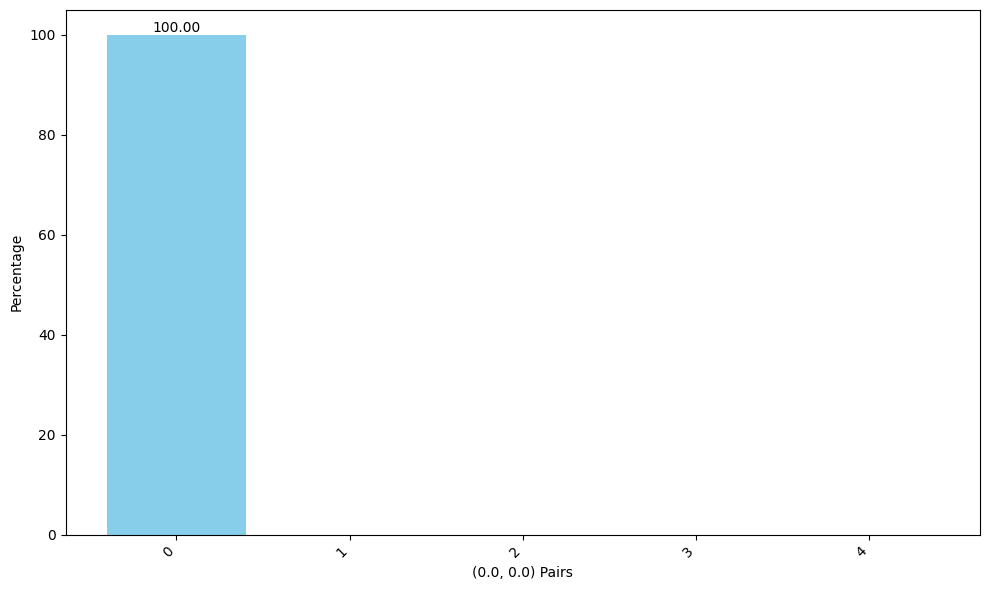

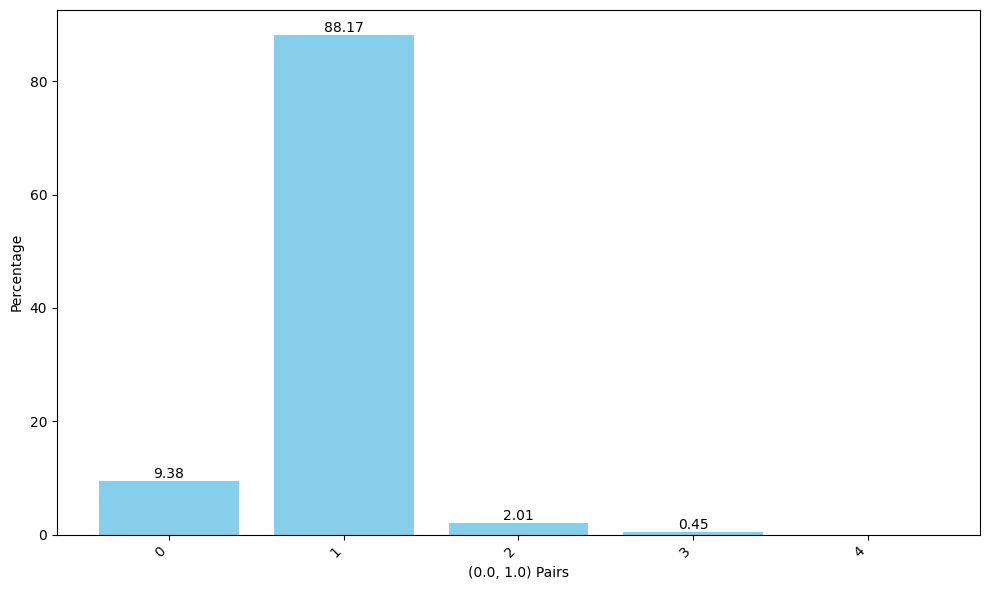

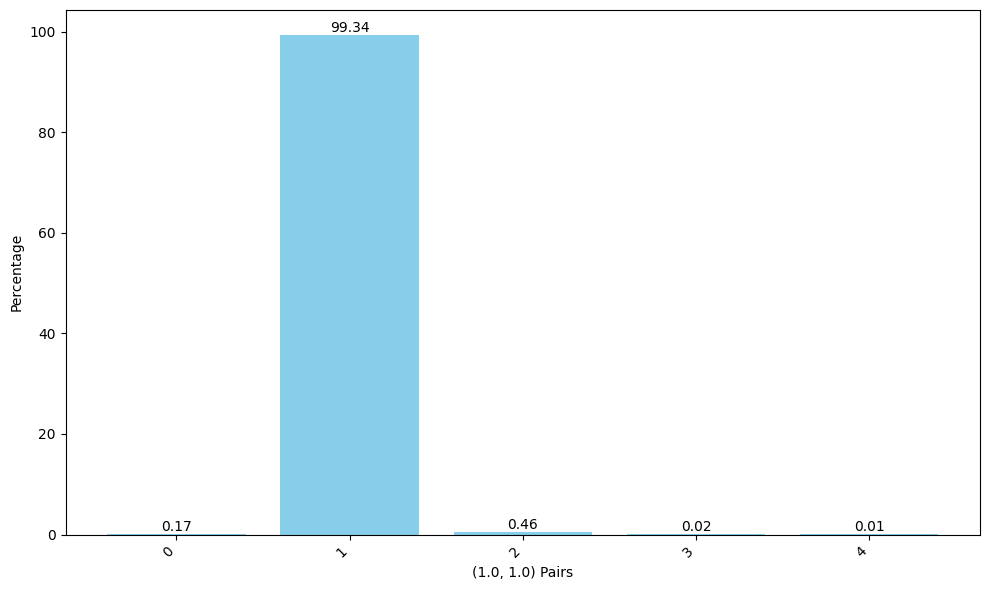

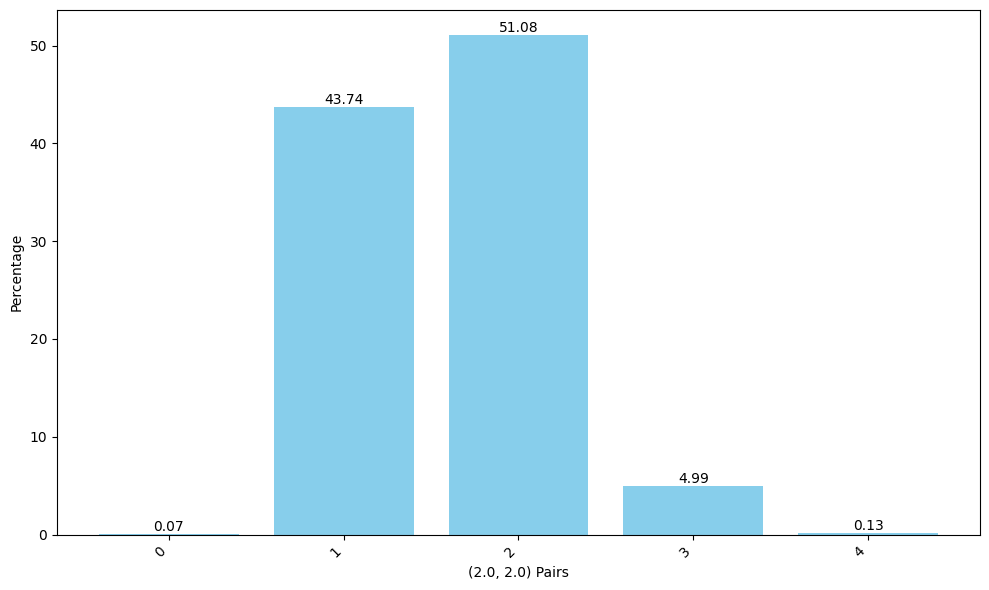

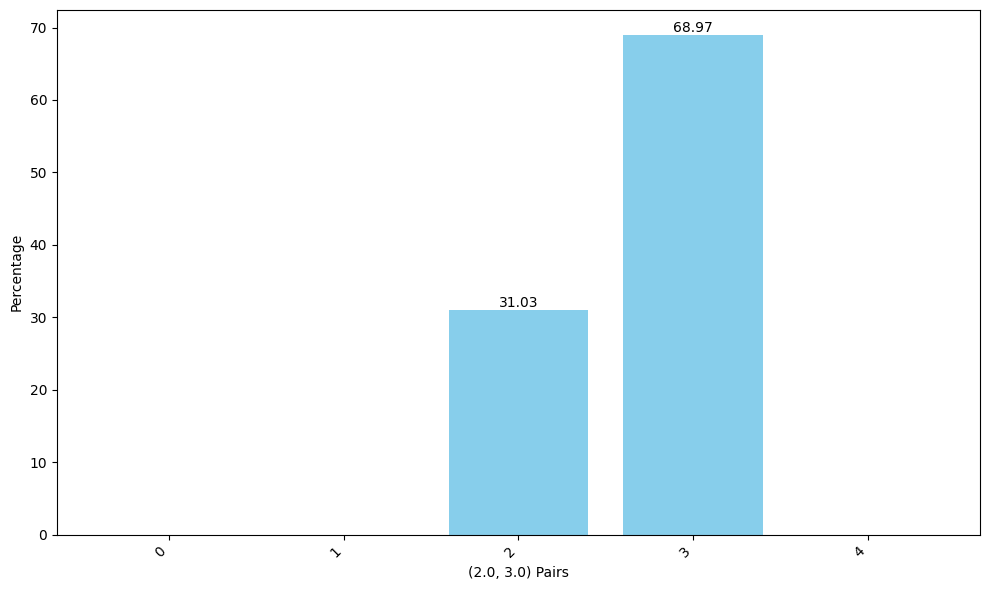

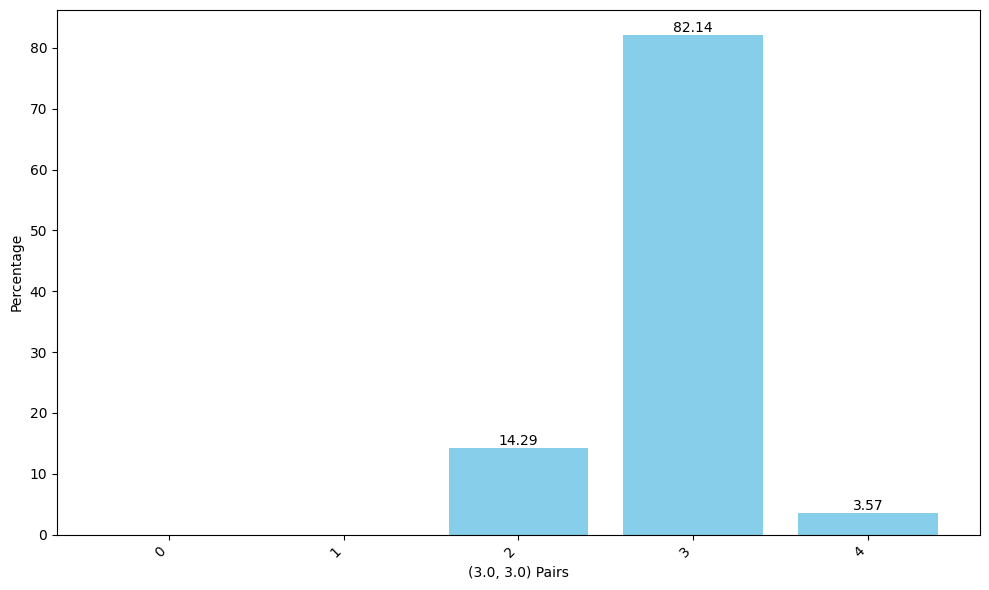

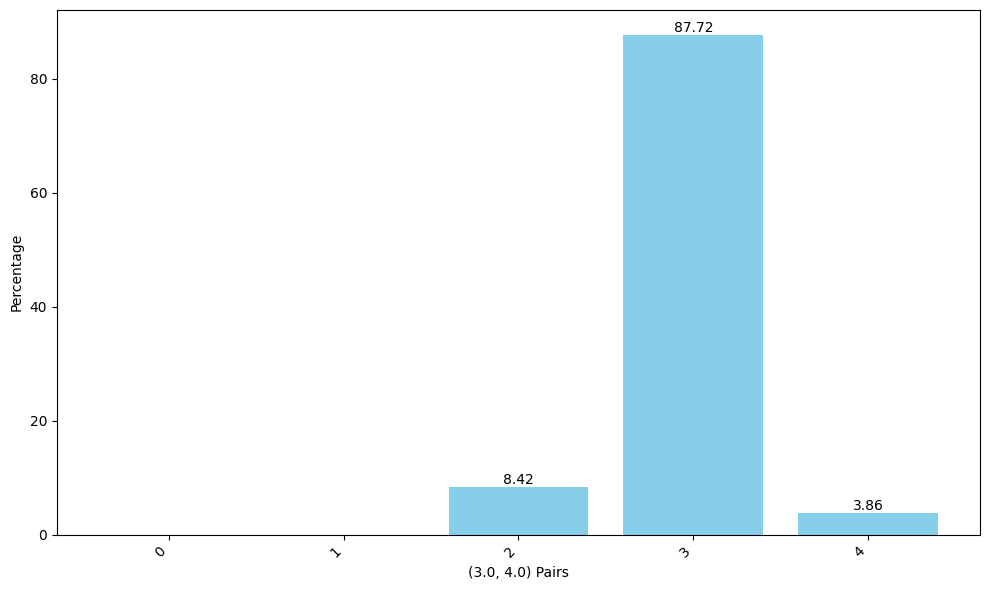

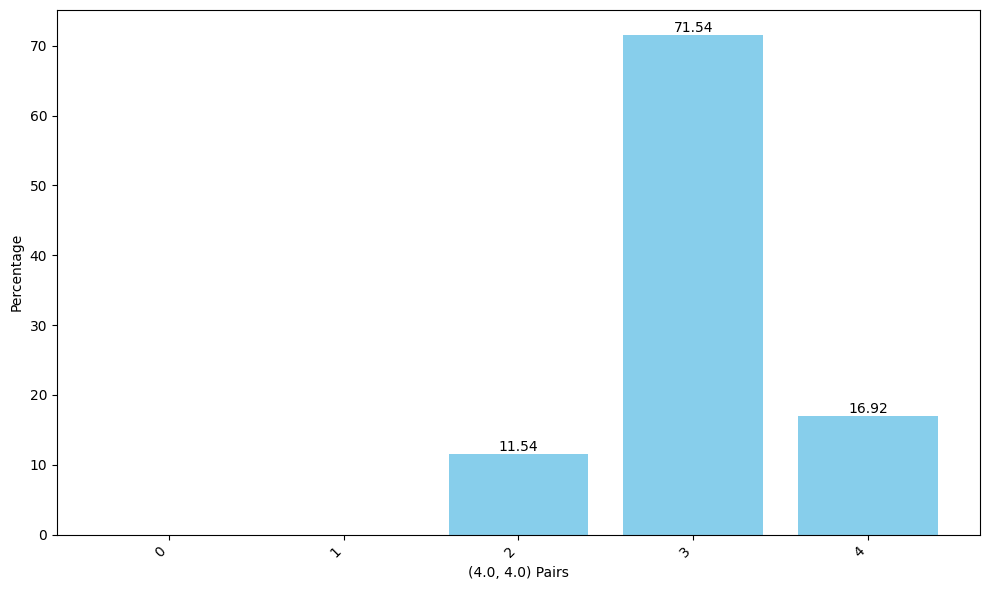

In [18]:
reporting(first_y_test, second_y_test, predicted_labels)


In [19]:
import numpy as np

unique_elements, counts = np.unique(pred, return_counts=True)
    
for element, count in zip(unique_elements, counts):
    print("Phần tử", element, "xuất hiện", count, "lần")


NameError: name 'pred' is not defined